# Feature Extraction

Requirements:

* [Download NFT Images](https://drive.google.com/file/d/1uo1mXRRkXcrY1u1bkWj_aEsoW6M3L_7o/view?usp=sharing) and Extract them in a folder named `NFTs`

Folder structure should be like this:

```bash
tree NFTs                                               
NFTs
└── collection
    ├── NFT-10005.png
    ├── NFT-10007.png
    ├── NFT-10009.png
    ├── NFT-10010.jpg
    ├── NFT-10013.jpg
    ...
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/ColabNotebooks/NFTs/NFT Images.zip" -d "/content/drive/My Drive/ColabNotebooks/NFTs/jsons/"

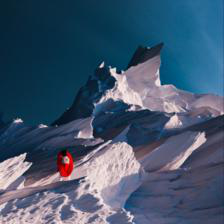

In [3]:
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img('/content/drive/My Drive/ColabNotebooks/NFTs/jsons/NFTs/collection/NFT-44420.jpg')
img

In [4]:
# Root folder for NFT Images
nft_images_root_folder = '/content/drive/My Drive/ColabNotebooks/NFTs/jsons/NFTs/'

In [5]:
import torch
import torch.nn as nn

from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
from torchvision.datasets import ImageFolder

from PIL import Image
from matplotlib import pyplot as plt

from glob import glob

from tqdm import tqdm

In [6]:
# Imagenet Statistics mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224, 224))])

In [7]:
# Helpers
concat = lambda x: np.concatenate(x, axis=0)
to_np  = lambda x: x.data.to('cpu').numpy()

### Feature Extractor from ResNet101

In [8]:
# Feature Extracor (This is no outdates, PyTorch supports feature extraction via an API)
class Lyaer4Extractor(torch.nn.Module):
  def __init__(self):
    super(Lyaer4Extractor, self).__init__()
    
    self.model = models.resnet101(pretrained=True)
    self.model.cuda()
    self.model.eval();
    
    self.a_embeddings = None
    
    def a_hook(module, input, output):
      self.a_embeddings = to_np(output)
      
    self.model._modules.get('layer4').register_forward_hook(a_hook)

  def forward(self, input):
    return self.model(input)

  def __repr__(self):
    return "Wrappper"

### Load images

In [9]:
# Create a ImageFolder
nft_dataset = ImageFolder(root=nft_images_root_folder, transform=preprocess)

# Create a DataLoader to feed everything to the GPU
nft_loader = torch.utils.data.DataLoader(nft_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
# Image names
list_of_files = [a[0] for a in nft_loader.dataset.imgs]

In [ ]:
# Save image names in a text file for further processing
with open('/content/drive/My Drive/ColabNotebooks/NFTs/jsons/NFTs/imagelist.txt', 'w') as f:
  f.write('\n'.join(list_of_files))

In [11]:
extractor = Lyaer4Extractor()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

### Extracting ...

In [12]:
embeddings = []
with torch.no_grad():
  for batch_idx, (data, target) in enumerate(tqdm(nft_loader)):
    data = data.cuda() # Using CUDA
    _ = extractor(data)
    embeddings.append(extractor.a_embeddings)

 84%|████████▎ | 188/225 [05:56<00:12,  3.02it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 225/225 [06:08<00:00,  1.64s/it]


In [ ]:
# Concatenate everything to have a one large array
embeddigns_np = concat(embeddings)

### Storing on the Disk

In [ ]:
# Store on the disk
#np.save('Embeddings.npy', embeddigns_np)